## Point Spread Function (PSF) Photometry

This notebook follows the photutils tutorial on PSF photometry (https://photutils.readthedocs.io/en/stable/psf.html). This photutils package provides classes to complete sub-tasks of PSF photometry, containing an implementation of the DAOPHOT algorithm (DAOPhotPSFPhotometry), discussed by Stetson in 1987 (https://ui.adsabs.harvard.edu/abs/1987PASP...99..191S/abstract). 

The DAOPHOT algorithm applies the loop FIND, GROUP, NSTAR, SUBTRACT, FIND until a number of iterations are completed or no more stars are found. Essentially, the process for DAOPhotPSFPhotometry is, estimating the sky background using either scalar or 2D backgrounds (https://photutils.readthedocs.io/en/stable/background.html), then an initial estimate for the locations of sources using a source detection algorithm is employed. A clustering algorithm is then applied to label the sources into groups, usually defined based on distance; the reason for this is to optimise the process. The next step is to fit the sources simultaneously for each group, for example using LevMarLSQFitter (https://docs.astropy.org/en/latest/api/astropy.modeling.fitting.LevMarLSQFitter.html). After this, the sources are then subtracted produces a residual image for which the process is repeated.

There are a number of classes for PSF Photometry: BasicPSFPhotometry, IterativelySubtractedPSFPhotometry and DAOPhotPSFPhotometry, explained in the tutorial link.

### Performing PSF Photometry

First consider a simulated example for stars where the PSF is assumed to be Gaussian. Create an image with 4 overlapping stars:

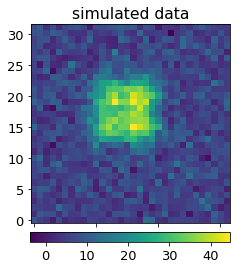

In [2]:
import numpy as np
from astropy.table import Table
from photutils.datasets import (make_random_gaussians_table, make_noise_image, make_gaussian_sources_image)

sigma_psf = 2.0

sources = Table()
sources['flux'] = [700, 800, 700, 800]
sources['x_mean'] = [12, 17, 12, 17]
sources['y_mean'] = [15, 15, 20, 20]
sources['x_stddev'] = sigma_psf * np.ones(4)
sources['y_stddev'] = sources['x_stddev']
sources['theta'] = [0, 0, 0, 0]
sources['id'] = [1, 2, 3, 4]
tshape = (32, 32)

image = (make_gaussian_sources_image(tshape, sources) +
         make_noise_image(tshape, distribution = 'poisson', mean = 6.) +
         make_noise_image(tshape, distribution = 'gaussian', mean = 0., stddev = 2.))

from matplotlib import rcParams
import matplotlib.pyplot as plt

rcParams['font.size'] = 13

plt.imshow(image, cmap = 'viridis', aspect = 1, interpolation = 'nearest', origin = 'lower')
plt.title('simulated data')
plt.colorbar(orientation='horizontal', fraction=0.046, pad=0.04)

In [13]:
# import required classes to set up an IterativelySubtractedPSFPhotometry object
from photutils.detection import IRAFStarFinder
from photutils.psf import IntegratedGaussianPRF, DAOGroup
from photutils.background import MMMBackground, MADStdBackgroundRMS
from astropy.modeling.fitting import LevMarLSQFitter
from astropy.stats import gaussian_sigma_to_fwhm

bkgrms = MADStdBackgroundRMS()
std = bkgrms(image)
iraffind = IRAFStarFinder(threshold = 3.5*std, fwhm = sigma_psf*gaussian_sigma_to_fwhm, minsep_fwhm = 0.01,
                          roundhi = 5.0, roundlo = -5.0, sharplo = 0.0, sharphi = 2.0)

daogroup = DAOGroup(2.0 * sigma_psf * gaussian_sigma_to_fwhm)
mmm_bkg = MMMBackground()
fitter = LevMarLSQFitter()
psf_model = IntegratedGaussianPRF(sigma=sigma_psf)

from photutils.psf import IterativelySubtractedPSFPhotometry

photometry = IterativelySubtractedPSFPhotometry(finder = iraffind,
                                                group_maker = daogroup,
                                                bkg_estimator = mmm_bkg,
                                                psf_model = psf_model,
                                                fitter = LevMarLSQFitter(),
                                                niters = 1,
                                                fitshape = (11, 11))

result_tab = photometry(image = image)
residual_image = photometry.get_residual_image()

print(result_tab)

       x_0               x_fit        ... y_0_unc iter_detected
------------------ ------------------ ... ------- -------------
12.566076728181244 11.802168338276694 ...     0.0             1
17.112309041490914 16.959316577589824 ...     0.0             1
 13.55668454643057 12.143729314394744 ...     0.0             1
 16.63220729305588 17.101195704324194 ...     0.0             1


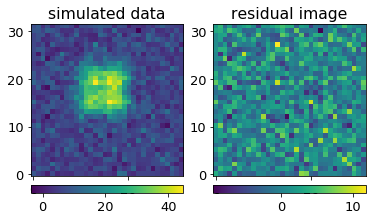

In [12]:
# compare the simulated and residual image

plt.subplot(1, 2, 1)
plt.imshow(image, cmap = 'viridis', aspect = 1, interpolation = 'nearest', origin = 'lower')
plt.title('simulated data')
plt.colorbar(orientation='horizontal', fraction=0.046, pad=0.04)

plt.subplot(1, 2, 2)
plt.imshow(residual_image, cmap = 'viridis', aspect = 1, interpolation = 'nearest', origin = 'lower')
plt.title('residual image')
plt.colorbar(orientation='horizontal', fraction=0.046, pad=0.04)
plt.show()

### Fitting additional parameters

PSF Photometry classes can be used to fit more model parameters than just flux and center positions, a more realistic case might involve fitting sky backgrounds, or shape parameters of galaxies. The tutorial shows an example using the sigma parameter in IntegratedGaussianPRF as a simple example of this feature. For PSF Photometry, this might not be preferable as the shape of the PSF should be fit by bright stars.

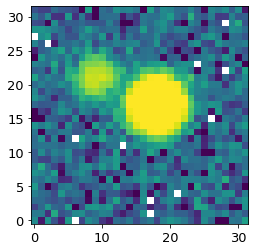

In [14]:
gaussian_prf = IntegratedGaussianPRF()
gaussian_prf.sigma.fixed = False
gaussian_prf.sigma.value = 2.05

# create a simulated image involving a brighter star overlapping a dim one
# redo list of imports here for completeness
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from photutils.datasets import (make_random_gaussians_table,
                                make_noise_image,
                                make_gaussian_sources_image)
from photutils.psf import (IterativelySubtractedPSFPhotometry,
                           BasicPSFPhotometry)
from photutils import MMMBackground
from photutils.psf import IntegratedGaussianPRF, DAOGroup
from photutils.detection import DAOStarFinder
from photutils.detection import IRAFStarFinder
from astropy.table import Table
from astropy.modeling.fitting import LevMarLSQFitter

sources = Table()
sources['flux'] = [10000, 1000]
sources['x_mean'] = [18, 9]
sources['y_mean'] = [17, 21]
sources['x_stddev'] = [2] * 2
sources['y_stddev'] = sources['x_stddev']
sources['theta'] = [0] * 2
tshape = (32, 32)
image = (make_gaussian_sources_image(tshape, sources) +
         make_noise_image(tshape, distribution='poisson', mean=6.) +
         make_noise_image(tshape, distribution='gaussian', mean=0., stddev=2.))

vmin, vmax = np.percentile(image, [5, 95])
plt.imshow(image, cmap = 'viridis', aspect = 1, interpolation = 'nearest', origin = 'lower',
           norm = LogNorm(vmin = vmin, vmax = vmax))

In [17]:
daogroup = DAOGroup(crit_separation = 8)
mmm_bkg = MMMBackground()
iraffind = IRAFStarFinder(threshold = 2.5 * mmm_bkg(image), fwhm = 4.5)
fitter = LevMarLSQFitter()
gaussian_prf = IntegratedGaussianPRF(sigma = 2.05)
gaussian_prf.sigma.fixed = False
itr_phot_obj = IterativelySubtractedPSFPhotometry(finder = iraffind,
                                                   group_maker = daogroup,
                                                   bkg_estimator = mmm_bkg,
                                                   psf_model = psf_model,
                                                   fitter = fitter,
                                                   fitshape = (11, 11),
                                                   niters = 2)

In [18]:
phot_results = itr_phot_obj(image)
phot_results['id', 'group_id', 'iter_detected', 'x_0', 'y_0', 'flux_0']

id,group_id,iter_detected,x_0,y_0,flux_0
int32,int32,int32,float64,float64,float64
1,1,1,17.994790281536737,17.00006718399457,9435.84573846856
1,1,2,9.050203720047236,21.047494876262935,979.4647112635362


In [20]:
#phot_results['sigma_0', 'sigma_fit', 'x_fit', 'y_fit', 'flux_fit']

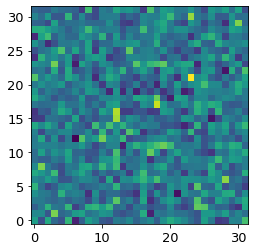

In [21]:
plt.imshow(itr_phot_obj.get_residual_image(), cmap = 'viridis', aspect = 1, interpolation = 'nearest', origin = 'lower')